<a href="https://colab.research.google.com/github/k-kotera/Jupyter_Implementations_ML/blob/master/ModelSeekingGAN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mode Seeking Generative Adversarial Networks for Diverse Image Synthesis

#### 参考
Qi Mao, Hsin-Ying Lee, Hung-Yu Tseng, Siwei Ma, Ming-Hsuan Yang.
Mode Seeking Generative Adversarial Networks for Diverse Image Synthesis.
https://arxiv.org/pdf/1903.05628v1.pdf

In [1]:
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, concatenate, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
#parameters
batch_size = 100
latent_dim = 100
condition_dim = 10# =num_of_classes
Height = 32
Width = 32
Channels = 3

In [3]:
#Generator_model
in_h = int(Height / 4)
in_w = int(Width / 4)

# latent vector input
generator_input1 = Input(shape=(latent_dim,))
# condition input
generator_input2 = Input(shape=(condition_dim,))
generator_input2_copy = Activation('linear')(generator_input2)
# concat 2 inputs
generator_input = concatenate([generator_input1, generator_input2])

x = Dense(in_h * in_w * 128, activation='tanh', name='g_dense1')(generator_input)
x = BatchNormalization()(x)
x = Reshape((in_h, in_w, 128))(x)

x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same')(x)
x = Activation('tanh')(x)

Generator = Model(inputs=[generator_input1, generator_input2], outputs=[x, generator_input2_copy], name="Generator")

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
Generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
g_dense1 (Dense)                (None, 8192)         909312      concatenate_1[0][0]              
__________

In [0]:
#Discriminator_model

discriminator_input1 = Input(shape=(Height, Width, Channels))
discriminator_input2 = Input(shape=(condition_dim,))

discriminator_input2_r = Reshape((1, 1, condition_dim))(discriminator_input2)
discriminator_input2_r = UpSampling2D((Height, Width))(discriminator_input2_r)

discriminator_input = concatenate([discriminator_input1, discriminator_input2_r])
x = Conv2D(64, kernel_size=4, strides=2, padding='same')(discriminator_input)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)
x = Conv2D(256, kernel_size=4, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dense(1, activation='sigmoid')(x)

Discriminator = Model(inputs=[discriminator_input1, discriminator_input2], outputs=x)

Discriminator.compile(loss='binary_crossentropy',
            optimizer='SGD',
            metrics=['accuracy'])

In [6]:
Discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1, 1, 10)     0           input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 32, 32, 10)   0           reshape_2[0][0]                  
__________________________________________________________________________________________________
concatenat

In [0]:
#GAN_model
Discriminator.trainable = False
gan_input1 = Input(shape=(latent_dim,))
gan_input2 = Input(shape=(condition_dim,))
gen_img = Generator([gan_input1, gan_input2])
gan_output = Discriminator(gen_img)
Gan = Model([gan_input1, gan_input2], gan_output)

gan_input_half1 = Lambda(lambda x: x[:int(batch_size/2)], output_shape=(latent_dim,))(gan_input1)
gan_input_half2 = Lambda(lambda x: x[int(batch_size/2):], output_shape=(latent_dim,))(gan_input1)

gen_img_half1 = Lambda(lambda x: x[:int(batch_size/2)], output_shape=(Height,Width,Channels))(gen_img[0])
gen_img_half2 = Lambda(lambda x: x[int(batch_size/2):], output_shape=(Height,Width,Channels))(gen_img[0])

alpha = 1
def gan_loss(y_true, y_pred):
    lz = K.mean(K.abs((gen_img_half1 - gen_img_half2)))/K.mean(K.abs((gan_input_half1 - gan_input_half2)))
    eps = 1e-6
    loss_lz = 1 / (lz + eps)
    return K.binary_crossentropy(y_true, y_pred) + alpha*loss_lz

Gan.compile(loss=gan_loss,
            optimizer='SGD',
            metrics=['accuracy'])

In [8]:
Gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
Generator (Model)               [(None, 32, 32, 3),  1076547     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            1721025     Generator[1][0]                  
          

In [0]:
#Load_cifar10dataset
(X_train, Y_train), (_, _) = cifar10.load_data()
Y_train_c = to_categorical(Y_train, 10)
X_train = X_train.reshape((X_train.shape[0],) + (Height, Width, Channels)).astype('float32')
X_train = (X_train - 127.5) / 127.5

valid_labels = np.ones((batch_size, 1))
fake_labels = np.zeros((batch_size, 1))

In [112]:
#Training
for epoch in tqdm(range(10000)):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs, labels = X_train[idx], Y_train_c[idx]
    random_latent_vectors = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = Generator.predict([random_latent_vectors, labels])

    # Train the discriminator
    d_loss_real = Discriminator.train_on_batch([imgs, labels], valid_labels)
    d_loss_fake = Discriminator.train_on_batch(generated_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the discriminator
    sampled_labels = to_categorical(np.random.randint(0, condition_dim, batch_size).reshape(-1, 1), num_classes=condition_dim)
    g_loss = Gan.train_on_batch([random_latent_vectors,  sampled_labels], valid_labels)

100%|██████████| 10000/10000 [07:09<00:00, 23.27it/s]


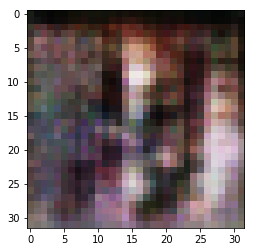

In [142]:
random_latent_vectors = np.random.normal(0, 1, (1, latent_dim))
condition = np.array(to_categorical([5], 10))
gen_image = Generator.predict([random_latent_vectors, condition])[0][0]

any_gen_image = np.array(gen_image*127.5+127.5,int)
plt.imshow(any_gen_image)